<a href="https://colab.research.google.com/github/Milonyash/testFastRCNN/blob/master/FasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar

--2019-05-02 19:26:35--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  11.6MB/s    in 36s     

2019-05-02 19:27:12 (12.2 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]



In [7]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [3]:
!tar -xvf VOCtrainval_06-Nov-2007.tar

VOCdevkit/
VOCdevkit/VOC2007/
VOCdevkit/VOC2007/Annotations/
VOCdevkit/VOC2007/Annotations/000005.xml
VOCdevkit/VOC2007/Annotations/000007.xml
VOCdevkit/VOC2007/Annotations/000009.xml
VOCdevkit/VOC2007/Annotations/000012.xml
VOCdevkit/VOC2007/Annotations/000016.xml
VOCdevkit/VOC2007/Annotations/000017.xml
VOCdevkit/VOC2007/Annotations/000019.xml
VOCdevkit/VOC2007/Annotations/000020.xml
VOCdevkit/VOC2007/Annotations/000021.xml
VOCdevkit/VOC2007/Annotations/000023.xml
VOCdevkit/VOC2007/Annotations/000024.xml
VOCdevkit/VOC2007/Annotations/000026.xml
VOCdevkit/VOC2007/Annotations/000030.xml
VOCdevkit/VOC2007/Annotations/000032.xml
VOCdevkit/VOC2007/Annotations/000033.xml
VOCdevkit/VOC2007/Annotations/000034.xml
VOCdevkit/VOC2007/Annotations/000035.xml
VOCdevkit/VOC2007/Annotations/000036.xml
VOCdevkit/VOC2007/Annotations/000039.xml
VOCdevkit/VOC2007/Annotations/000041.xml
VOCdevkit/VOC2007/Annotations/000042.xml
VOCdevkit/VOC2007/Annotations/000044.xml
VOCdevkit/VOC2007/Annotations/000046.

In [0]:
%matplotlib inline
import torch
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
import torch.optim as optim
import torchvision.models as models
import torch.utils.data
from PIL import Image
import xml.etree.ElementTree as ET
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
import math
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [0]:
class VOC2007Dataset(Dataset):
    def __init__(self,path,train=True,resize=True,target_width=600,target_height=600,transform=None):
        self.transform = transform
        self.path = path
        self.train = train
        self.target_width = target_width
        self.target_height = target_height
        self.resize=resize
        #meta
        self.VOC2007labels=['background','person','bird','cat','cow','dog','horse','sheep',
                           'aeroplane','bicycle','boat','bus','car','motorbike', 'train',
                            'bottle','chair','diningtable','pottedplant','sofa','tvmonitor']
            
        #paths
        self.image_path = path + '/JPEGImages/'
        self.annotation_path = path + '/Annotations/'
        self.trainset = path + '/ImageSets/Main/train.txt'
        self.valset = path + '/ImageSets/Main/val.txt'
        self.split_file = self.trainset if train else self.valset
        
        # load split
        with open(self.split_file,'r') as f:
            self.availables = f.readlines()
        
        # length            
        self.my_length=len(self.availables)
        
        
        self.toTensor = transforms.ToTensor()
        
    def __len__(self):
        return self.my_length
    
    def __getitem__(self,index):
        curr = self.availables[index][:-1]
        image_path = self.image_path+curr+'.jpg'
        # Open Image
        img = Image.open(image_path).convert('RGB')
        if self.transform is not None:
            raw_img = self.transform(img)
            tmp = torch.zeros([1,3,raw_img.size(1),raw_img.size(2)])
            tmp[0,:,:,:]=raw_img
            raw_img=tmp
            
        # Open Annotations (XML)
        tree = ET.parse(self.annotation_path + curr + '.xml')
        root = tree.getroot()
        labels=[]
        bboxes=[]
        for object in root.findall('object'):
            #labels.append(self.VOC2007labels.index(object.find('name').text))
            labels.append(self.VOC2007labels.index(object.find('name').text))
            
            bbox=[0,0,0,0]
            bbox[0]=int(object.find('bndbox').find('xmin').text) #top-left x
            bbox[1]=int(object.find('bndbox').find('ymin').text) #top-left y
            
            bbox[2]=int(object.find('bndbox').find('ymax').text) - bbox[1] #height
            bbox[3]=int(object.find('bndbox').find('xmax').text) - bbox[0] #width
            
            if self.resize:
                img = torch.zeros([1,3,self.target_height,self.target_width])
                curr_width = float(root.find('size').find('width').text)
                curr_height = float(root.find('size').find('height').text)
                height_longer = curr_width<=curr_height
                
                if height_longer:
                    
                    # resize image
                    resize_width = int((curr_width/curr_height)*self.target_height)
                    img[0,:,:,:resize_width] = F.interpolate(raw_img,size=(self.target_height,resize_width))
                    # resize the bounding box according to the image resize
                    resize_height = self.target_height
                    bbox[0] = int(round(float(bbox[0])/curr_width * resize_width))
                    bbox[1] = int(round(float(bbox[1])/curr_height * self.target_height))
                    bbox[2] = int(round(float(bbox[2])/curr_height * self.target_height))
                    bbox[3] = int(round(float(bbox[3])/curr_width * resize_width))
                else:
                    # resize image
                    resize_height = int((curr_height/curr_width)*self.target_width)
                    tmp =F.interpolate(raw_img,size=(resize_height,self.target_width))
                    img[0,:,:resize_height ,:] = F.interpolate(raw_img,size=(resize_height,self.target_width))
                    # resize the bounding box according to the image resize
                    resize_width = self.target_width
                    bbox[0] = int(round(float(bbox[0])/curr_width * self.target_width))
                    bbox[1] = int(round(float(bbox[1])/curr_height * resize_height))
                    bbox[2] = int(round(float(bbox[2])/curr_height * resize_height))
                    bbox[3] = int(round(float(bbox[3])/curr_width * self.target_width))
                    

            # move bbox locator from top-left corner to center
            bbox[0]=bbox[0]+0.5*bbox[3]
            bbox[1]=bbox[1]+0.5*bbox[2]
            
            bboxes.append(bbox)
            
        
        return (img[0,:,:,:],labels,bboxes)

In [0]:
VOC2007_PATH = 'VOCdevkit/VOC2007'
BATCH_SIZE = 2
num_workers = 4
pin_memory = True
N_cls = 1 # Normalize value for classification
N_reg = 2400 # Normalize value for regression
reg_weight = 10 # Weight applied to bbox regression loss

In [0]:
def iou(pred, gt, height=600, width=600):
    '''
    Outputs IOU evaluation metric between two bounding boxes given by the center
    coordinates and its width and height.
    
    @params pred: 1x4 array (x, y, h, w)
    @params gt: 1x4 array (x, y, h, w)
    '''
    # Inefficient but simplest algorithm that works
    pred_plot = np.zeros((height,width))
    gt_plot = np.zeros((height,width))
    x,y,w,h = pred.detach().cpu().numpy()
    x_min, x_max = int(np.clip(x-w/2,0,width)), int(np.clip(x+w/2,0,width))
    y_min, y_max = int(np.clip(y-h/2,0,height)), int(np.clip(y+h/2,0,height))
    pred_plot[y_min:y_max, x_min:x_max] = 1
    x,y,w,h = gt
    x_min, x_max = int(np.clip(x-w/2,0,width)), int(np.clip(x+w/2,0,width))
    y_min, y_max = int(np.clip(y-h/2,0,height)), int(np.clip(y+h/2,0,height))
    gt_plot[y_min:y_max, x_min:x_max] = 1
    
    overlap_plot = np.sum(np.minimum(pred_plot, gt_plot))
    union = np.sum(np.maximum(pred_plot, gt_plot))
    
    iou = float(overlap_plot)/union
    return iou

def assign_label_bbox(roi_bboxes, gt_bboxes, gt_labels):
    '''
    Assigns gt classification label and gt bboxes to roi bboxes
        - roi bbox with highest IOU of any gt bbox
        - roi bbox with >0.7 IOU of any gt bbox
        - ignore bbox with 0.3 < IOU < 0.7
    
    @params roi_bboxes: NxRx4 (R is number of proposals)
    @params gt_bboxes: NxR'x4 (R' is number of gt bounding boxes)
    @params gt_labels: NxR'x1 (R' is number of gt bounding boxes)
    '''
    assigned_bboxes = np.zeros(roi_bboxes.shape)
    assigned_labels = np.zeros((roi_bboxes.shape[0], roi_bboxes.shape[1], 1))
    for batch in range(len(roi_bboxes)):
        ious = np.zeros((len(roi_bboxes[batch]), len(gt_bboxes[batch])))
        for i, box in enumerate(roi_bboxes[batch]):
            for j, gt_box in enumerate(gt_bboxes[batch]):
                ious[i,j] = iou(box, gt_box)
        gt_max_roi = np.argmax(ious, 0) # indices of roi_bboxes with highest iou for each gt bbox 
        roi_max_gt = np.argmax(ious, 1) # indices of gt_bboxes with highest iou for each roi bbox
        
        for i, box in enumerate(roi_bboxes[batch]):
            roi_max_gt_index = roi_max_gt[i]
            if ious[i, roi_max_gt_index] > 0.7: # iou overlap is >0.7 for some gt
                assigned_bboxes[batch,i] = gt_bboxes[batch,roi_max_gt_index]
                assigned_labels[batch,i] = gt_labels[batch,roi_max_gt_index]
            elif i in gt_max_roi: # roi has highest iou for some gt bbox
                gt_index = np.where(gt_max_roi==i)[0][0]
                if ious[i, gt_index] > 0.3: # make sure reasonable overlap
                    assigned_bboxes[batch,i] = gt_bboxes[batch,gt_index]
                    assigned_labels[batch,i] = gt_labels[batch,gt_index]
            elif ious[i, roi_max_gt_index] > 0.3: # label will be -1 (ignore)
                assigned_bboxes[batch,i] = np.array([-1,-1,-1,-1])
                assigned_labels[batch,i] = np.array([-1])
            # Else label will be 0, indicating background class
                        
    return assigned_bboxes, assigned_labels


def rcnn_loc_loss(pred_loc, gt_loc):
    '''
    ***REQUIRES CHANGING WHEN USING ANCHORS***
    
    Calculates bounding box regression loss
    N - batch size, R - number of bounding boxes per image
    Returns Nx1 losses (for each item in batch)
    
    @params pred_loc: NxRx4 pytorch array
    @params gt_loc: NxRx4 pytorch array
    '''
    loc_loss = nn.SmoothL1Loss()(pred_loc, gt_loc)
    return loc_loss

def loss_fn(roi_bboxes, pred_bboxes, pred_labels, assigned_bboxes, assigned_labels):
    '''
    Calculates bounding box regression loss and classification loss for R bounding boxes
    
    @params pred_bboxes: [NxRx80] predicted bounding boxes
    @params pred_labels: [NxRxC] predicted one-hot vector labels for predicted bounding boxes 
    @params gt_bboxes: [NxRx4] gt bounding boxes
    @params gt_labels: [NxRx1] gt labels for bounding boxes    
    '''
    nonnegative_indices = np.where(assigned_labels != -1)[1]
    positive_indices = np.where(assigned_labels > 0)[1]
    cls_loss = nn.CrossEntropyLoss()(
        pred_labels[:,nonnegative_indices][:,0,:], 
        torch.tensor(assigned_labels[:,nonnegative_indices][:,0,0]).cuda().long()
        )
    for i in range(1,pred_labels[:,nonnegative_indices].shape[1]):
        cls_loss += nn.CrossEntropyLoss()(
            pred_labels[:,nonnegative_indices][:,i,:], 
            torch.tensor(assigned_labels[:,nonnegative_indices]).cuda().long()[:,i,0]
            )
    label = int(assigned_labels[:,positive_indices][0,0,0] - 1)
    loc_loss = rcnn_loc_loss(
        pred_bboxes[:,positive_indices[0],label*4:(label+1)*4], 
        (torch.tensor(assigned_bboxes[:,positive_indices[0]]).float().cuda() - roi_bboxes[:,positive_indices[0]].float().cuda())/50
        )
    for i in range(1,pred_bboxes[:,positive_indices].shape[1]):
        label = int(assigned_labels[:,positive_indices][0,i,0] - 1)
        loc_loss += rcnn_loc_loss(
            pred_bboxes[:,positive_indices[i],label*4:(label+1)*4], 
            (torch.tensor(assigned_bboxes[:,positive_indices[i]]).float().cuda() - roi_bboxes[:,positive_indices[i]].float().cuda())/50
            )
    return cls_loss, loc_loss

def eval_metrics(roi_bboxes, pred_bboxes,pred_labels,assigned_bboxes,assigned_labels):
    '''
    Returns average classification accuracy, average IOU for bounding boxes
    and a list of predictions and ious (-1 means ignored) 
    
    @params pred_bboxes: [NxRx4] predicted bounding boxes
    @params pred_labels: [NxRxC] predicted one-hot vector labels for predicted bounding boxes 
    @params assigned_bboxes: [NxRx4] gt bounding boxes
    @params assigned_labels: [NxRx1] gt labels for bounding boxes    
    '''
    cls_accs, cls_accs_avg = [], []
    iou_accs, iou_accs_avg = [], []
    batches, proposals, _ = roi_bboxes.shape
    for i in range(batches):
        for j in range(proposals):
            cls_pred = np.argmax(pred_labels[i,j])
            if assigned_labels[i,j][0] != -1: # If label of bounding box is not ignored
                if cls_pred == assigned_labels[i,j][0]:
                    cls_accs_avg.append(1)
                    cls_accs.append(1)
                else:
                    cls_accs_avg.append(0)
                    cls_accs.append(0)
                if assigned_labels[i,j][0] != 0: # If label of bounding box is not background
                    label = int(assigned_labels[i,j] - 1)
                    bbox_iou = iou(pred_bboxes[i,j][label*4:(label+1)*4]*50+roi_bboxes[i,j], assigned_bboxes[i,j])
                    iou_accs_avg.append(bbox_iou)
                    iou_accs.append(bbox_iou)
            else:
                cls_accs.append(-1)
                iou_accs.append(-1)
        
    return np.mean(cls_accs_avg), np.mean(iou_accs_avg), cls_accs, iou_accs

In [0]:
def convert_center_to_corner(x, y, h, w):
    corner_x = x-w/2
    corner_y = y-h/2
    new_h = h
    new_w = w
    if corner_x < 0:
        new_w += corner_x
        corner_x = 0
    if corner_y < 0:
        new_h += corner_y
        corner_y = 0
    return int(corner_x), int(corner_y), int(new_h), int(new_w)
    
def ROIPool(feature_map, rois, outh=7, outw=7):
    '''
    Extact a fixed-length feature vector from the feature map for each ROI
    convert ROI of any size into a small feature map with a fixed spatial extent of HxW (7x7)
    Refer to section 2.1 in fast RCNN paper
    
    input:
        feature_map: 1 x C x map_size x map_size (tensor)
        rois: M x 4 (tensor) - M is the # of rois (c_x, c_y, height, width)
    return:
        M x C x 7 x 7
    
    '''
    #xy->yx for rois
    torch.index_select(rois,1,torch.tensor([1,0,3,2]).cuda())
    
    N,C,H,W = feature_map.size()
    M = rois.size(0)
    
    # extract ROI
    output = torch.Tensor(M,C,outh,outw).cuda()
#     output = torch.Tensor(M,C,outh,outw)
    
    for i in range(M):
        # crop map of interesting
        roi = rois[i].int()   
        new_x = int(roi[0]-0.5*roi[3])
        new_y = int(roi[1]-0.5*roi[2])
        moi = feature_map[:,:,new_y:new_y+roi[3],new_x:new_x+roi[2]]
        # pooling
        output[i,:,:,:] = nn.functional.adaptive_max_pool2d(moi, output_size=(outh,outw))
    return output
    
class RPN(nn.Module):
    # TODO for XING QIAN
    def __init__(self):
        super(RPN, self).__init__()
    'do something!'

class Combine(nn.Module):
    def __init__(self, classifier,n_class,n_hidden_unit=4096):
        super(Combine, self).__init__()
        self.classifier = classifier
#         self.fc6 = nn.Linear(n_hidden_unit,n_hidden_unit)
#         self.fc7 = nn.Linear(n_hidden_unit,n_hidden_unit)
        self.relu = nn.ReLU()
        self.bbox = nn.Linear(n_hidden_unit,4*20)
        self.classification = nn.Linear(n_hidden_unit,n_class)

    def forward(self, feature_map, rois):
        '''
        input
            feature_maps: batch_size x num_channels x size x size
            rois: Nx M x 4, where M is # of roi offset for each image
            *note: we assume batch_size=1 for similicity
        output:
            bboxes: # N x M x 4: prediction of bboxes in *real images*
            classes: # N x M x K: score of each classes #K = num_class+1
        '''
        pools = ROIPool(feature_map, rois)
        pools = pools.view(pools.size(0), -1)
        fc = self.classifier(pools)
        fc = self.relu(fc)
#         fc = self.fc6(pools)
#         fc = self.fc7(fc)
        bboxes_offset = self.bbox(fc)
        classes = self.classification(fc)
        return bboxes_offset, classes
    
class FasterRCNN(nn.Module):
    def __init__(self, feature_extractor,rpn,combine):
        super(FasterRCNN, self).__init__()
        self.feature_extractor = feature_extractor
#         self.rpn = rpn
        self.combine = combine
    
    def forward(self, x, rois):
        ''' x - 3d input image'''
        feature_map = self.feature_extractor(x)
#         rois = self.rpn(x)
        bboxes, classes = self.combine(feature_map, rois)
        return bboxes, classes

In [0]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
#                              transforms.Resize((224,224)),
#                              transforms.RandomHorizontalFlip(),
                             transforms.ToTensor(),
                             normalize,
                         ])
trainloader = torch.utils.data.DataLoader(VOC2007Dataset(VOC2007_PATH,train=True,resize=True,transform=transform),
                              batch_size=1,
                                shuffle=True,
                                num_workers=num_workers,
                                pin_memory=pin_memory)
testloader = torch.utils.data.DataLoader(VOC2007Dataset(VOC2007_PATH,train=False,resize=True,transform=transform),
                              batch_size=1,
                                shuffle=False,
                                num_workers=num_workers,
                                pin_memory=pin_memory)

In [0]:
def jiggle_bboxes(bboxes, max_h=600, max_w=600):
    '''
    @params bboxes: list of 4-dimensional tensors for bounding boxes (image level)
    '''
    ret_bboxes = []
    for i in range(len(bboxes)):
        for j in range(5):
            bbox = []
            bbox.append(torch.clamp(torch.add(bboxes[i][0],torch.randint(-50,50,(1,), dtype=torch.float64)),0,599))
            bbox.append(torch.clamp(torch.add(bboxes[i][1],torch.randint(-50,50,(1,), dtype=torch.float64)),0,599))            
            bbox.append(torch.clamp(torch.add(bboxes[i][2],torch.randint(-50,50,(1,), dtype=torch.long)),0,599))            
            bbox.append(torch.clamp(torch.add(bboxes[i][3],torch.randint(-50,50,(1,), dtype=torch.long)),0,599))            
            ret_bboxes.append(bbox)
        bbox = []
        bbox.append(torch.clamp(torch.add(bboxes[i][0],torch.randint(-5,5,(1,), dtype=torch.float64)),0,599))
        bbox.append(torch.clamp(torch.add(bboxes[i][1],torch.randint(-5,5,(1,), dtype=torch.float64)),0,599))            
        bbox.append(torch.clamp(torch.add(bboxes[i][2],torch.randint(-5,5,(1,), dtype=torch.long)),0,599))            
        bbox.append(torch.clamp(torch.add(bboxes[i][3],torch.randint(-5,5,(1,), dtype=torch.long)),0,599))            
        ret_bboxes.append(bbox)
#         ret_bboxes.append(bboxes[i])
    return ret_bboxes

In [9]:
num_class = 21
vgg16 = models.vgg16(True)
features = list(vgg16.features)[:30] #not all because wanna make the size of feature map greater than 7x7
feature_extractor = nn.Sequential(*features)
classifiers = list(vgg16.classifier)[:-1] #keep all the fc,relu,dropout except for last fc
classifiers = nn.Sequential(*classifiers)
combiner = Combine(classifiers,n_class=num_class)
print('1')
model = torch.nn.DataParallel(FasterRCNN(feature_extractor=feature_extractor,rpn=None,combine=combiner)).cuda()
print('2')
optimizer = optim.Adam(model.parameters(), lr = 0.00001)

#checkpoint = torch.load("test_80_20.pth")
#model.load_state_dict(checkpoint)

1
2


In [11]:
for epoch in range(10):
  acc_lst = []
  iou_lst = []
  loss_lst = []
  model.eval()
  print ('1')
  for i, data in enumerate(tqdm(testloader,desc='Train epoch %d'%epoch)):
        images,gt_labels,gt_bboxes = data
        x = images.cuda()
        rand_bboxes = jiggle_bboxes(gt_bboxes)
        rois = np.array(rand_bboxes)*37/600
        rois = torch.tensor(rois.astype(int)).cuda()
        if len(torch.nonzero(rois[:,2:])) == len(rois[:,2:])*2: # Make sure height and width for ROI is not 0
            outputs = model(x, rois)
            assigned_bboxes, assigned_labels = assign_label_bbox(
                torch.tensor(rand_bboxes).unsqueeze(0).float(),
                torch.tensor(gt_bboxes).unsqueeze(0),
                torch.tensor(gt_labels).unsqueeze(0).unsqueeze(2))
            cls_loss, loc_loss = loss_fn(
                torch.tensor(rand_bboxes).unsqueeze(0), 
                outputs[0].unsqueeze(0), 
                outputs[1].unsqueeze(0),
                assigned_bboxes,
                assigned_labels
                )
            #loss
            losses = cls_loss + loc_loss
            metrics = eval_metrics(
                torch.tensor(rand_bboxes).unsqueeze(0).float().cuda(),
                outputs[0].unsqueeze(0),
                outputs[1].unsqueeze(0).detach().cpu().numpy(),
                assigned_bboxes,
                assigned_labels
                )
            acc_lst.append(metrics[0])
            iou_lst.append(metrics[1])
            loss_lst.append(losses.item())
print(np.mean(acc_lst))
print(np.mean(iou_lst))
print(np.mean(loss_lst))

1



1



1



1



1



1



1



1



1



1



0.048708140276769694
0.748610715869025
20.542635505256673


In [0]:
import PIL.Image as Image
import PIL.ImageColor as ImageColor
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
import scipy.misc 
import copy

def visualize_bbox_and_labels_separate(img,gt_bboxes=np.asarray([]),
            roi_bboxes=np.asarray([]),
            pred_bboxes=np.asarray([]),
            gt_labels=None,roi_labels=None,pred_labels=None,savename='test'):
    '''
    input: (numpy arrays)
        @ img: 3 x H x W
        @ gt_bboxes: R x 4
        @ roi_bboxes: R x 4
        @ pred_bboxes: R x 4
        @ gt_labels: R x 1
        @ pred_labels: R x 1
    
    output:
        Nothing. But will save image in given path and display it if you are using some IDE
        @ red box - ground truth
        @ green box - roi association
        @ yellow box - predition
    
    '''
    
    VOC2007labels=['','background','person',
                           'bird','cat','cow','dog','horse','sheep',
                           'aeroplane','bicycle','boat','bus','car','motorbike', 'train',
                            'bottle','chair','diningtable','pottedplant','sofa','tvmonitor']
    
    color_codes = ['red','green','yellow'] #gt,roi,pred
    # convert to np image
#     img = img.cpu().numpy()
    img = np.uint8(np.transpose(img, (1, 2, 0))*255)
    #image = np.uint8(np.transpose(image, (1, 2, 0))*255)
   
    # get labels
    gt_labels = [VOC2007labels[i+1] for i in list(gt_labels)]
    roi_labels = [VOC2007labels[i+1] for i in list(roi_labels)]
    pred_labels = [VOC2007labels[i+1] for i in list(pred_labels)]
    
    def drawBBox(image,bboxes,class_names,color_codes,savename):
        for i in range(bboxes.shape[0]):
            # if miss, continue (0.3 < IOU < 0.7)
#             if class_names[0] =='': 
#                 break
            # process bbox    
            bbox = bboxes[i,:]#*2000/600
            xmin,ymin,xmax,ymax = bbox[0]-0.5*bbox[3],bbox[1]-0.5*bbox[2],\
                            bbox[0]+0.5*bbox[3],bbox[1]+0.5*bbox[2]
            # draw bbox
            draw_bounding_box_on_image_array(
            image,ymin,xmin,ymax,xmax,
            color=color_codes[i],
            thickness=3,
            display_str_list=class_names[i]+str(i),
            use_normalized_coordinates=False)
        return image
        
    
    # Draw bbox on image on each group
    for i in range(len(gt_labels)):
        if gt_labels[i] != '':
            image = copy.deepcopy(img)
            label = int(VOC2007labels.index(gt_labels[i]) - 2)
            curr_bboxes = np.zeros((3,4))
            if gt_labels[i] == 'background':
                curr_bboxes[0],curr_bboxes[1],curr_bboxes[2] = gt_bboxes[i],roi_bboxes[i],roi_bboxes[i]
            else:
                curr_bboxes[0],curr_bboxes[1],curr_bboxes[2] = gt_bboxes[i],roi_bboxes[i],roi_bboxes[i]+pred_bboxes[i][label*4:(label+1)*4]*50

            curr_labels = np.asarray([gt_labels[i],roi_labels[i],pred_labels[i]])

            image = drawBBox(image,curr_bboxes,curr_labels,color_codes,savename)
            # save image in given path
    #         scipy.misc.imsave('visualization/%s_%s.jpg'%(savename,str(i)),image)
            # display image on IDE
            plt.figure(figsize=(10,10))
            plt.imshow(image)
            plt.show()

    
    

def visualize_bbox_and_labels(img,gt_bboxes=np.asarray([]),
            roi_bboxes=np.asarray([]),
            pred_bboxes=np.asarray([]),
            gt_labels=None,roi_labels=None,pred_labels=None,savename='test.jpg'):
    '''
    input: (numpy arrays)
        @ img: 3 x H x W
        @ gt_bboxes: R x 4
        @ roi_bboxes: R x 4
        @ pred_bboxes: R x 4
        @ gt_labels: R x 1
        @ pred_labels: R x 1
    
    output:
        Nothing. But will save image in given path and display it if you are using some IDE
        @ red box - ground truth
        @ green box - roi association
        @ yellow box - predition
    
    '''
    
    VOC2007labels=['','background','person',
                           'bird','cat','cow','dog','horse','sheep',
                           'aeroplane','bicycle','boat','bus','car','motorbike', 'train',
                            'bottle','chair','diningtable','pottedplant','sofa','tvmonitor']
       
    # convert to np image
    image = img.cpu().numpy()
    #image = skimage.transform.resize(npimg,(3,2400,2400))
    image = np.uint8(np.transpose(image, (1, 2, 0))*255)
   
    # get labels
    gt_labels = [VOC2007labels[i+1] for i in list(gt_labels)]
    roi_labels = [VOC2007labels[i+1] for i in list(roi_labels)]
    pred_labels = [VOC2007labels[i+1] for i in list(pred_labels)]
    
    def drawBBox(bboxes,class_names,color):
        for i in range(bboxes.shape[0]):
            # if miss, continue (0.3 < IOU < 0.7)
            if class_names[i]=='': 
                continue
            # process bbox    
            bbox = bboxes[i,:]#*2000/600
            xmin,ymin,xmax,ymax = bbox[0]-0.5*bbox[3],bbox[1]-0.5*bbox[2],\
                            bbox[0]+0.5*bbox[3],bbox[1]+0.5*bbox[2]
            # draw bbox
            draw_bounding_box_on_image_array(
            image,ymin,xmin,ymax,xmax,
            color=color,
            thickness=3,
            display_str_list=class_names[i]+str(i),
            use_normalized_coordinates=False)
        return image
    
    # Draw bbox on image on each group
    image = drawBBox(gt_bboxes,gt_labels,'red')
    image = drawBBox(roi_bboxes,roi_labels,'green')
    image = drawBBox(pred_bboxes,pred_labels,'yellow')
    
    # display image on IDE
    fig = plt.imshow(image)
    
    # save image in given path
    scipy.misc.imsave('visualization/'+savename,image)
    
    
    
'''
Note below functions are borrowed from tensorflow repo at
https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py with tiny modification
'''
def draw_bounding_box_on_image_array(image,
                                     ymin,
                                     xmin,
                                     ymax,
                                     xmax,
                                     color='red',
                                     thickness=4,
                                     display_str_list=(),
                                     use_normalized_coordinates=True):
    """Adds a bounding box to an image (numpy array).
    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.
    Args:
    image: a numpy array with shape [height, width, 3].
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: list of strings to display in box
                      (each to be shown on its own line).
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
    """
    #image_pil = Image.fromarray(np.uint8(image)).convert('RGB')
    image_pil = Image.fromarray(image)
    draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color,
                             thickness, display_str_list,
                             use_normalized_coordinates)
    np.copyto(image, np.array(image_pil))
    
    
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color='red',
                               thickness=4,
                               display_str_list=(),
                               use_normalized_coordinates=True):
    """Adds a bounding box to an image.
    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.
    Each string in display_str_list is displayed on a separate line above the
    bounding box in black text on a rectangle filled with the input 'color'.
    If the top of the bounding box extends to the edge of the image, the strings
    are displayed below the bounding box.
    Args:
    image: a PIL.Image object.
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: list of strings to display in box
                      (each to be shown on its own line).
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
    """
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    if use_normalized_coordinates:
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    else:
        (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
        draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)
    try:
        font = ImageFont.truetype('arial.ttf', size=200)
    except IOError:
        font = ImageFont.load_default()

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle(
        [(left, text_bottom - text_height - 2 * margin), (left + text_width,
                                                          text_bottom)],
        fill=color)
        draw.text(
        (left + margin, text_bottom - text_height - margin),
        display_str,
        fill='black',
        font=font)
        text_bottom -= text_height - 2 * margin

In [0]:
mean=np.array([0.485, 0.456, 0.406]).reshape((3,1,1)) 
std=np.array([0.229, 0.224, 0.225]).reshape((3,1,1))

model.eval()
for i, data in enumerate(trainloader):
    images,gt_labels,gt_bboxes = data
    x = images.cuda()
    rand_bboxes = jiggle_bboxes(gt_bboxes)
    rois = np.array(rand_bboxes)*37/600
    rois = torch.tensor(rois.astype(int)).cuda()
    if len(torch.nonzero(rois[:,2:])) == len(rois[:,2:])*2: # Make sure height and width for ROI is not 0
        outputs = model(x, rois)
        optimizer.zero_grad()
        assigned_bboxes, assigned_labels = assign_label_bbox(
            torch.tensor(rand_bboxes).unsqueeze(0).float(),
            torch.tensor(gt_bboxes).unsqueeze(0),
            torch.tensor(gt_labels).unsqueeze(0).unsqueeze(2))
    break

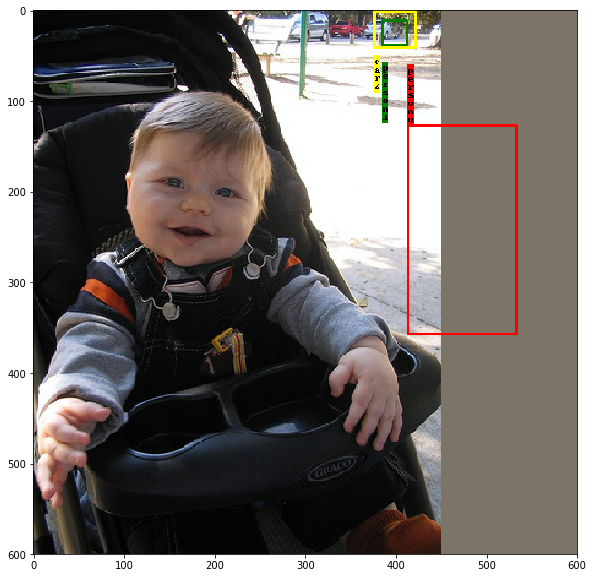

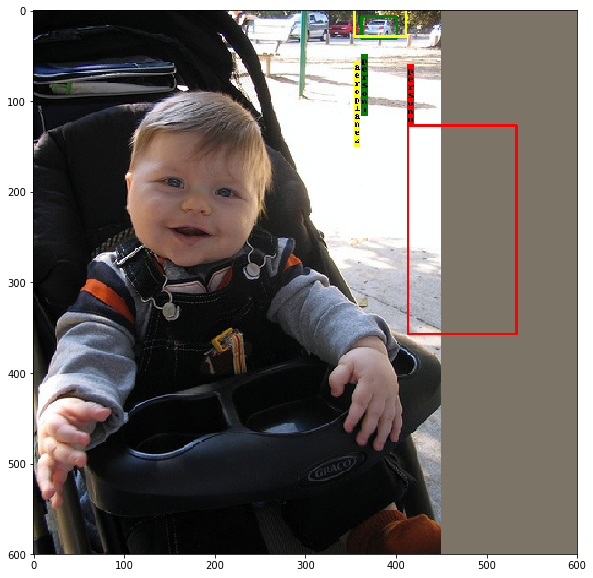

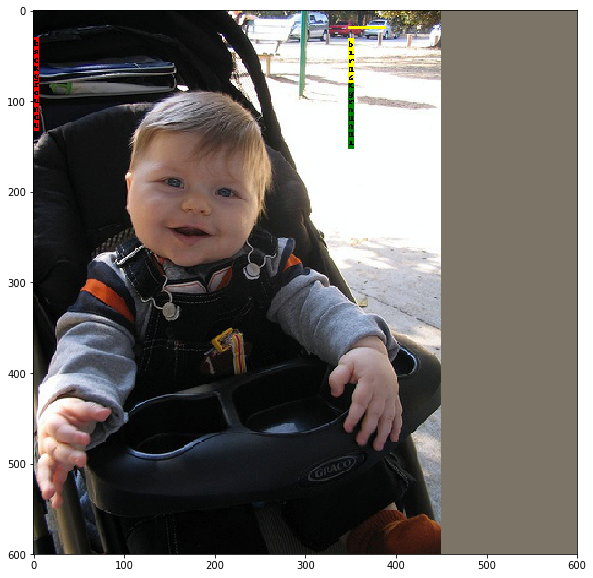

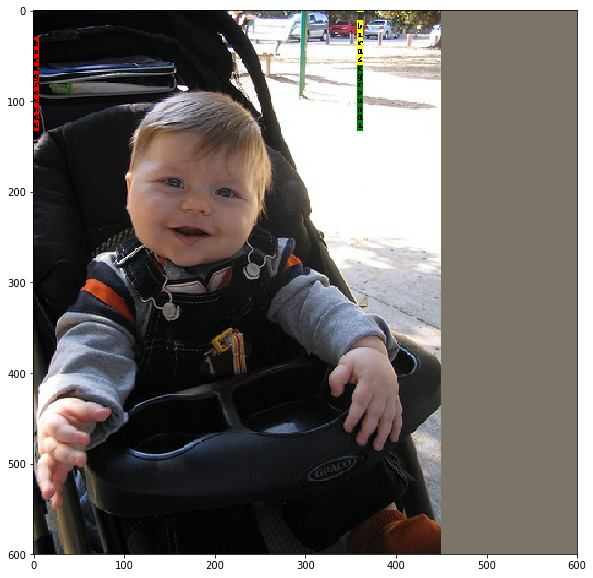

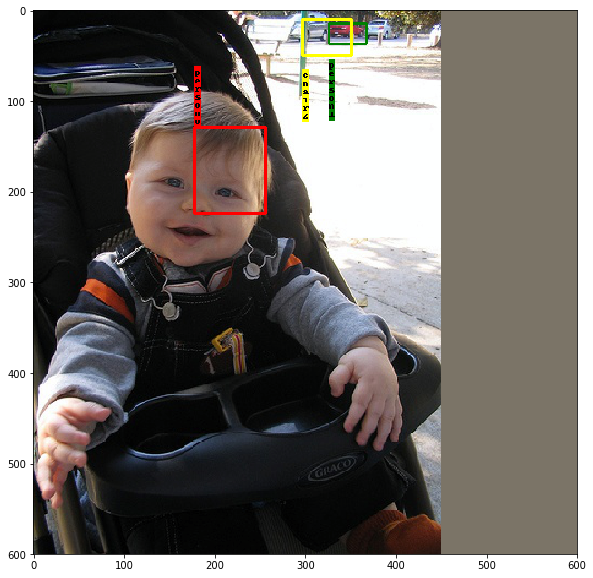

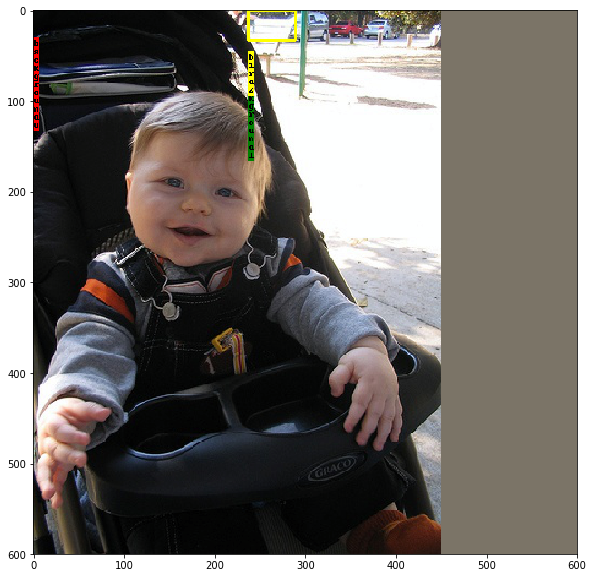

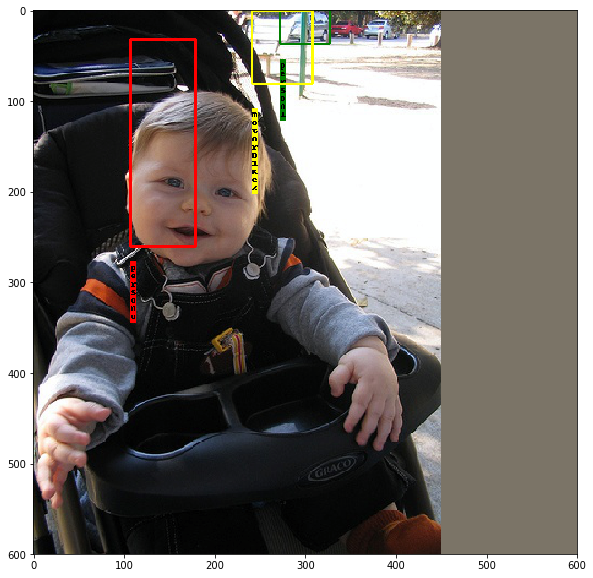

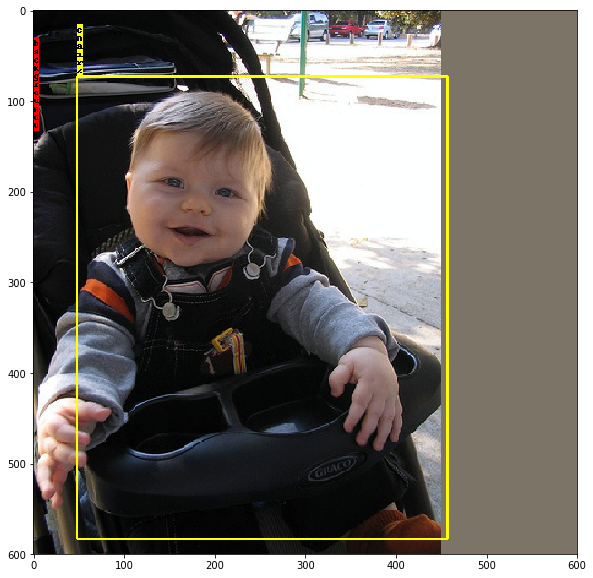

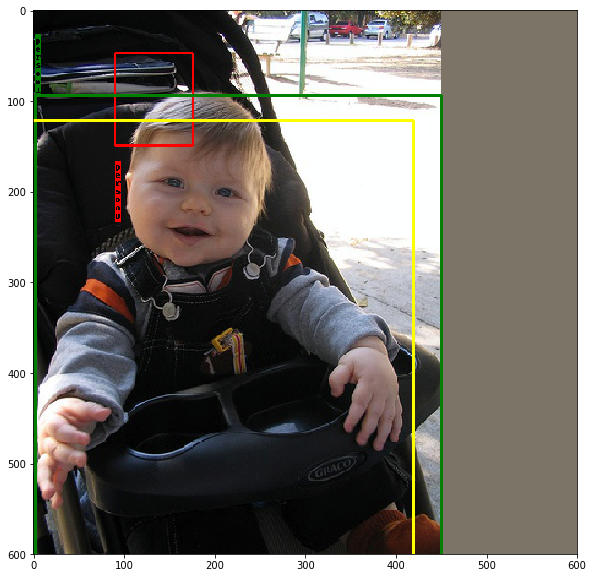

IndexError: ignored

In [16]:
visualize_bbox_and_labels_separate(
    images[0].cpu().numpy()*std + mean,
    gt_bboxes=np.asarray(assigned_bboxes[0]),
    gt_labels=np.asarray(assigned_labels[0][:,0]).astype(int),
    roi_labels=np.asarray(assigned_labels[0][:,0]).astype(int),
    pred_labels=np.argmax(np.asarray(outputs[1].detach().cpu()),1),
    roi_bboxes=np.asarray(rand_bboxes),
    pred_bboxes=np.asarray(outputs[0].detach().cpu())
)